# A Pupil Dilation Technique to Test Developmental Differences in Visual

Synchrony

# Introduction

This tutorial demonstrates how to extract population pupil dilation
synchrony using a simulated dataset. The analysis focuses on comparing
pupil dilation patterns between two age groups across multiple video
stimuli.

> **Warning**
>
> The pupil dilation data used in this tutorial is simulated. Please do
> not interpret the results as representative of actual physiological
> responses.

The simulated dataset comprises:

-   2 age groups: Children and Adults

-   10 subjects per age group

-   10 video stimuli

# Data Import and Visualization

We begin by importing the necessary libraries and loading the simulated
data.

In [ ]:
library(tidyverse)
library(zoo)

Hz = 20
window_sizeP = Hz * 2
window_size_Ttest = Hz * 4

# read the data
db = read.csv('Simulated_data.csv')

Next, we visualize the pupil dilation data for both groups across all
videos comparing children and adults with the same id number.

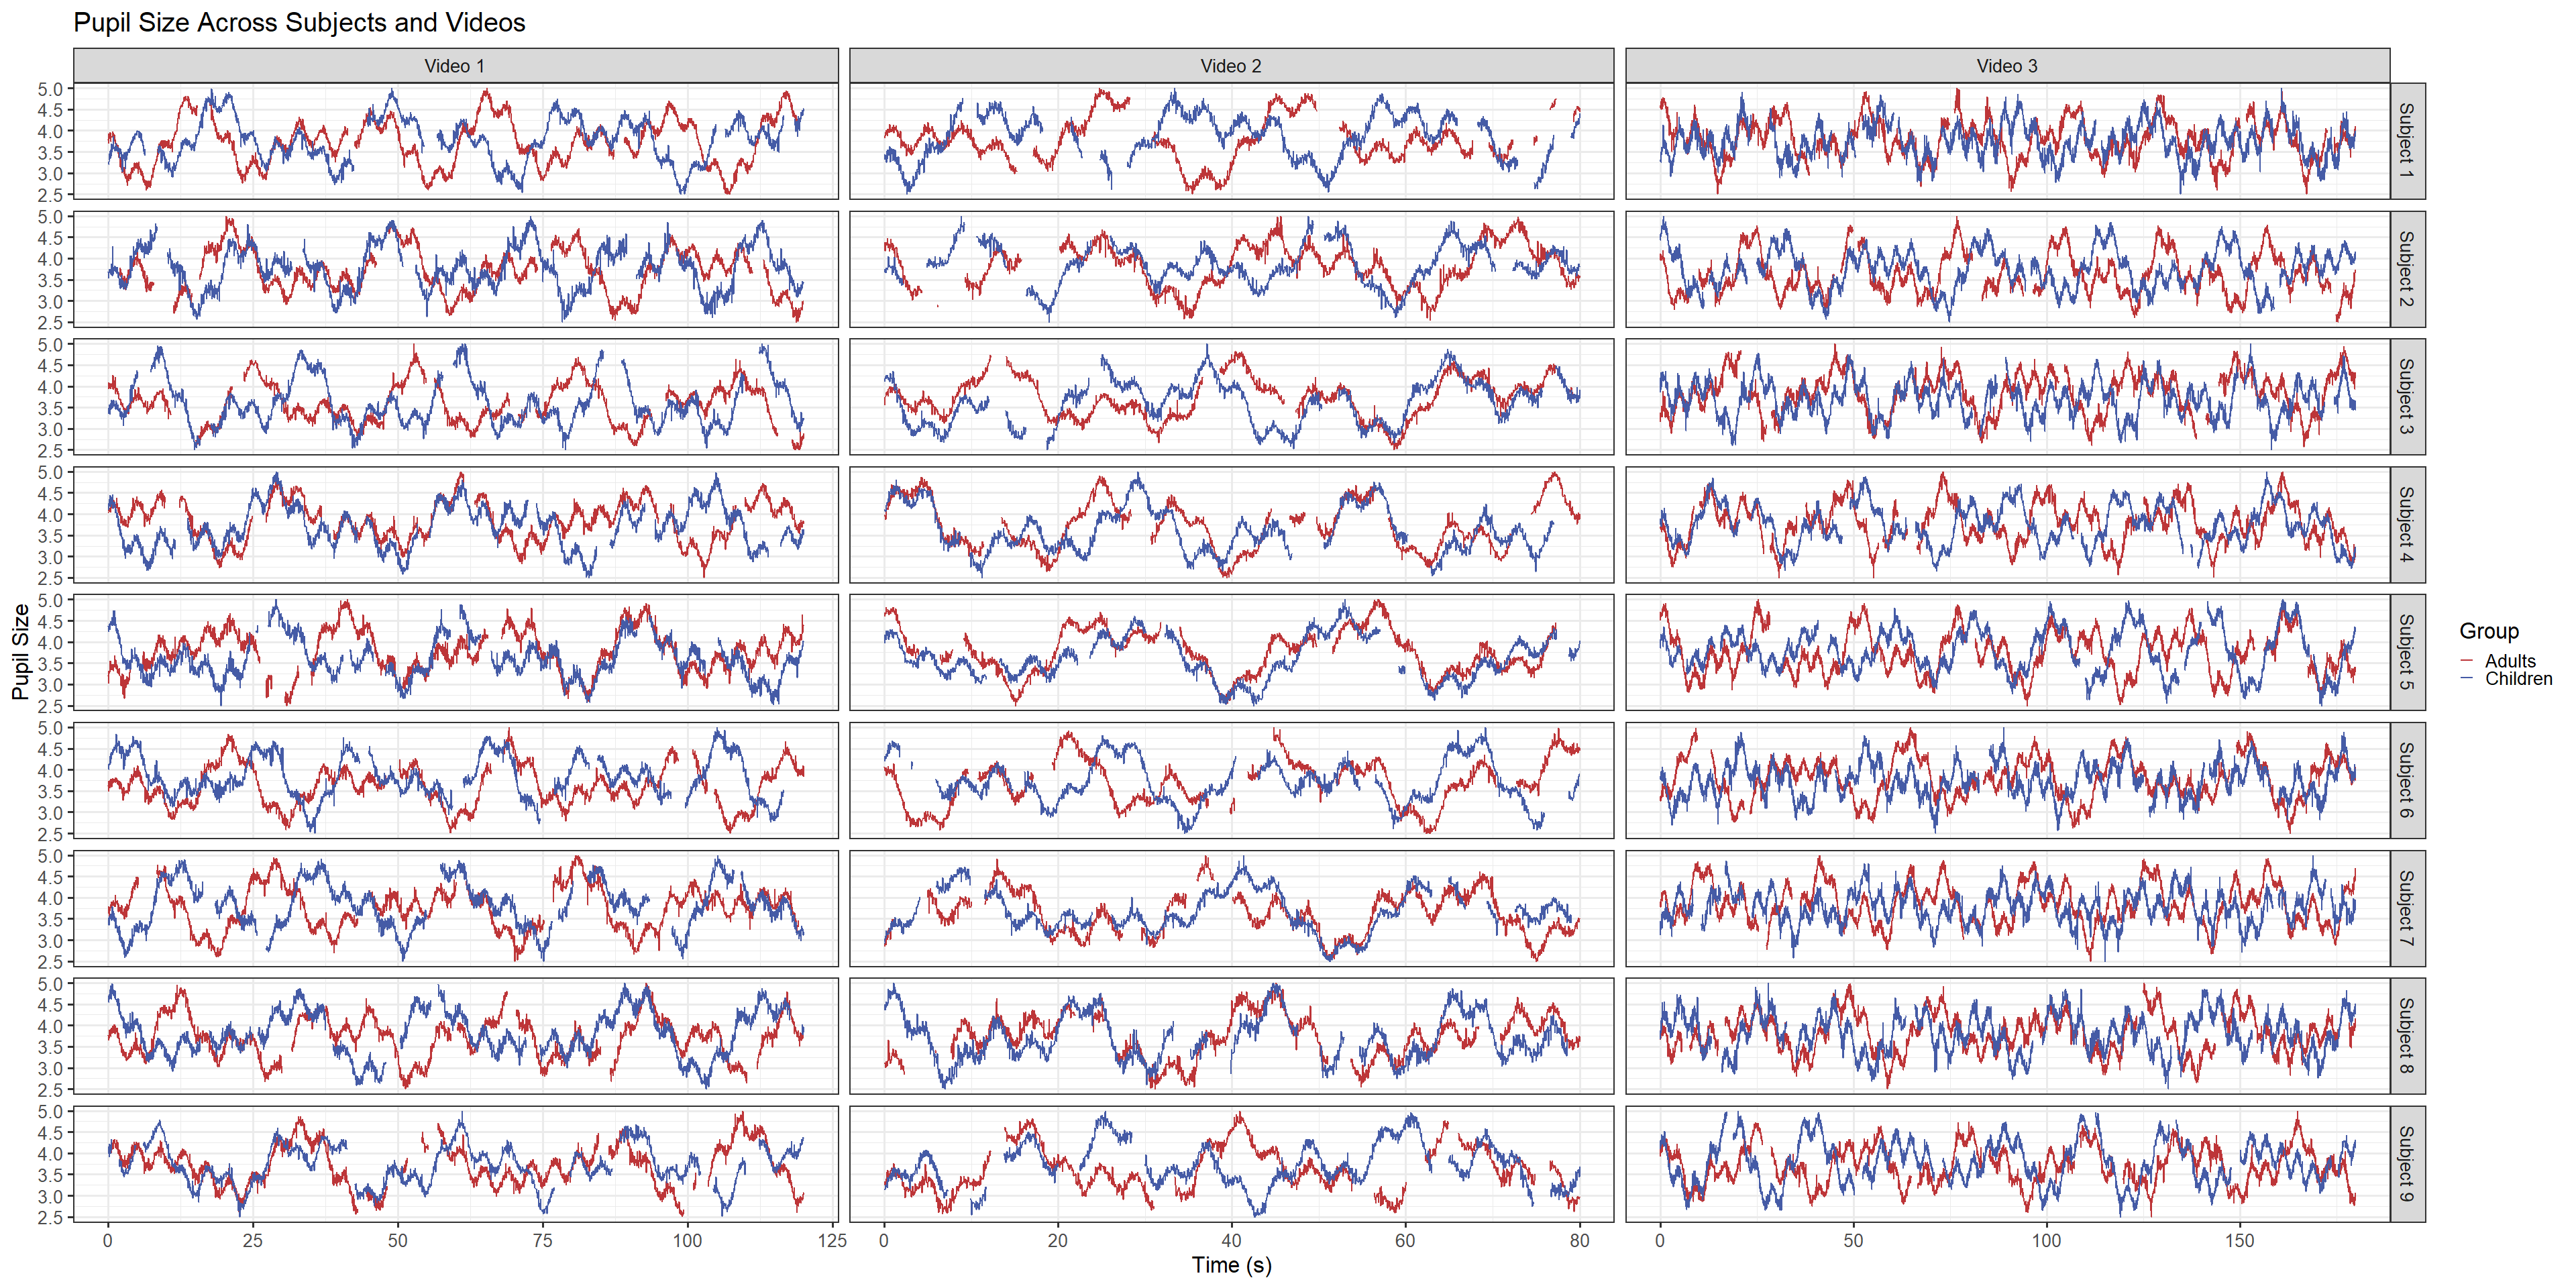

In [ ]:
db %>% 
  mutate(id_num = str_c('Subject ', str_sub(Subject, -1, -1))) %>% 
  ggplot( aes(x = Seconds, y = PupilSize, color = Group)) +
  geom_line(lwd =1.05) +
  facet_grid(id_num~Video, scales = 'free') +
  theme_bw(base_size = 25) +
  labs(title = "Pupil Size Across Subjects and Videos",
       x = "Time (s)",
       y = "Pupil Size")+
  scale_color_manual(values = c("#BD3538", "#455BA6"))

# Prepare the data

To analyze pupil dilation synchrony between Children and Adults, we need
to prepare our data by:

-   Separating the data by age Group

-   Reshaping the data to a wide format for easier analysis

-   Split the data to a list of dataframes based on the videos

-   Removing first column to only keep the data

We’ll create two lists of dataframes, one for each age group:

In [ ]:
# Split datafrme in chidlren and adults
Children =  db %>%
  filter(Group == 'Children') %>% 
  arrange(Video) %>% 
  pivot_wider(names_from = Subject, values_from = PupilSize,
              id_cols = c("Seconds", "Video")) 

Adults = db %>% 
  filter(Group == 'Adults') %>% 
  arrange(Video) %>% 
  pivot_wider(names_from = Subject, values_from = PupilSize,
              id_cols = c("Seconds", "Video")) 


# Create list of dataframe for children
Children_list = Children %>%
  split(.$Video) %>% 
  map(select, -(1:2))
  
# Create list of dataframe for adults
Adults_list = Adults %>%
  split(.$Video) %>% 
  map(select, -(1:2))

These lists contain separate dataframes for each video, with columns
representing individual subjects’ pupil sizes. This structure
facilitates the extraction of running pupil synchrony in subsequent
analyses.

# Pupil Synchrony

## Synchrony Calculation

To calculate the running pupil synchrony we will define three functions:

-   `calculate_running_correlation()`

-   `calc_correlation()`

-   `average_fisher_z_transform()`

### `calculate_running_correlation()`

This is the main function that uses the `rollapply` function from the
`zoo` package to apply a sliding window analysis. It calculates
correlations over a specified window size across the entire dataset.

### `calc_correlation()`

This function is applied to each window of data. It performs these
steps:

-   Checks if more than 75% of the window contains NA values. If so, it
    returns NA.
-   Discards columns (subjects) where more than 75% of values are NA.
-   Calculates the correlation matrix for the current window using
    `cor()`.
-   Applies Fisher’s z-transformation using
    `average_fisher_z_transform()`.

### `average_fisher_z_transform()`

This function applies Fisher’s z-transformation to the correlation
matrix and returns the average correlation. Here’s a step-by-step
breakdown:

-   Checks if a significant portion of columns have `NA` values.
-   Extracts the lower triangle of the correlation matrix.
-   Adjusts perfect correlations slightly to avoid infinite z-scores.
-   Applies Fisher’s z-transformation using `atanh()`.
-   Calculates the mean z-score.
-   Converts the mean z-score back to the correlation scale using
    `tanh()`.

> **Note**
>
> The Fisher z-transformation is a statistical method used to convert
> correlation coefficients into z-scores. It is used in this analysis
> because the correlation coefficients are not normally distributed and
> their variance changes depending on the strength of the correlation,
> which can lead to biased results when averaging or performing other
> statistical operations. The z-transformation normalizes the
> distribution of correlations and stabilizes their variance, making it
> possible to perform more accurate statistical analyses.

In [ ]:
#### Running correlation
# This function calculates running correlations over a specified window size.
calculate_running_correlation = function(Matrix, window_sizeP, threshold = 0.75) {
  # Define a function to calculate correlation for each window
  calc_correlation = function(window_rows) {
    
    # Check if more than 75% of the window has NA values
    if (sum(is.na(window_rows)) > threshold * prod(dim(window_rows))) {
      return(NA)
    } else {
      # Discard columns where more than 75% of values are NA
      window_rows[, colMeans(is.na(window_rows)) > 0.75] = NA
      
      # Calculate the correlation matrix for the current window and apply Fisher's z-transform
      correlation_matrix = cor(window_rows, use = "pairwise.complete.obs")
      correlation = average_fisher_z_transform(correlation_matrix)
      return(correlation)
    }
  }
  
  # Apply the calc_correlation function to each rolling window in the Matrix
  correlation_matrices = rollapply(Matrix, width = window_sizeP, FUN = calc_correlation,
                                   by.column = FALSE, align = "center", partial = TRUE)
  
  return(correlation_matrices)
}



#### Extract Average normalized person correlation
# This function applies Fisher's z-transformation to the correlation matrix and returns the average correlation.
average_fisher_z_transform = function(corr_matrix, threshold = 0.75) {
  # Check if a significant portion of columns have NA values
  if (sum(colSums(is.na(corr_matrix)) >= ncol(corr_matrix) - 1) > threshold * ncol(corr_matrix)) {
    return(NA)
  }
  # Take the lower triangle of the correlation matrix, excluding the diagonal
  lower_tri = corr_matrix[lower.tri(corr_matrix)]
  
  # Adjust perfect correlations slightly to avoid infinite z-scores
  lower_tri[lower_tri == 1] = 1 - 1e-10
  lower_tri[lower_tri == -1] = -1 + 1e-10
  
  # Apply Fisher's z transformation
  z_scores = atanh(lower_tri)
  
  # Calculate the mean z-score and convert back to the correlation scale
  average_z_score = mean(z_scores, na.rm = TRUE)
  average_correlation = tanh(average_z_score)
  
  return(average_correlation)
}

### Running the function and finalize the data

Having defined our functions, we can now apply them to the dataframes in
our lists. We’ll use `lapply()` to efficiently run the
`calculate_running_correlation()` function on each element of our lists,
which is analogous to using a for loop but more concise and often faster
in R. Thanks to our data arrangement earlier, we can easily integrate
the calculated synchrony values into our original dataframes by
combining the list of synchrony using `do.call(c, )`.

We start by calculating the synchrony for both children and adults:

In [ ]:
Children_synchrony = lapply(Children_list, calculate_running_correlation, window_sizeP = window_sizeP)
Adults_sycnhrony = lapply(Adults_list, calculate_running_correlation, window_sizeP = window_sizeP)


  
# Add sycnhrony values to original dataframe
Children_synchrony = Children %>% 
  select(1:2) %>%
  mutate(Group = 'Children',
         Synchrony = do.call(c, Children_synchrony))

Adults_sycnhrony = Adults %>% 
  select(1:2) %>%
  mutate(Group = 'Adults',
         Synchrony = do.call(c, Adults_sycnhrony))

Final_synchrony = bind_rows(Children_synchrony, Adults_sycnhrony)

In this code:

-   We apply `calculate_running_correlation()` to each element in
    Children_list and Adults_list.
-   We then add the calculated synchrony values to the original
    dataframes, along with a *Group* identifier.
-   Finally, we combine the children and adults dataframes into a single
    dataframe.

Now that we have our combined data, we can visualize the results:

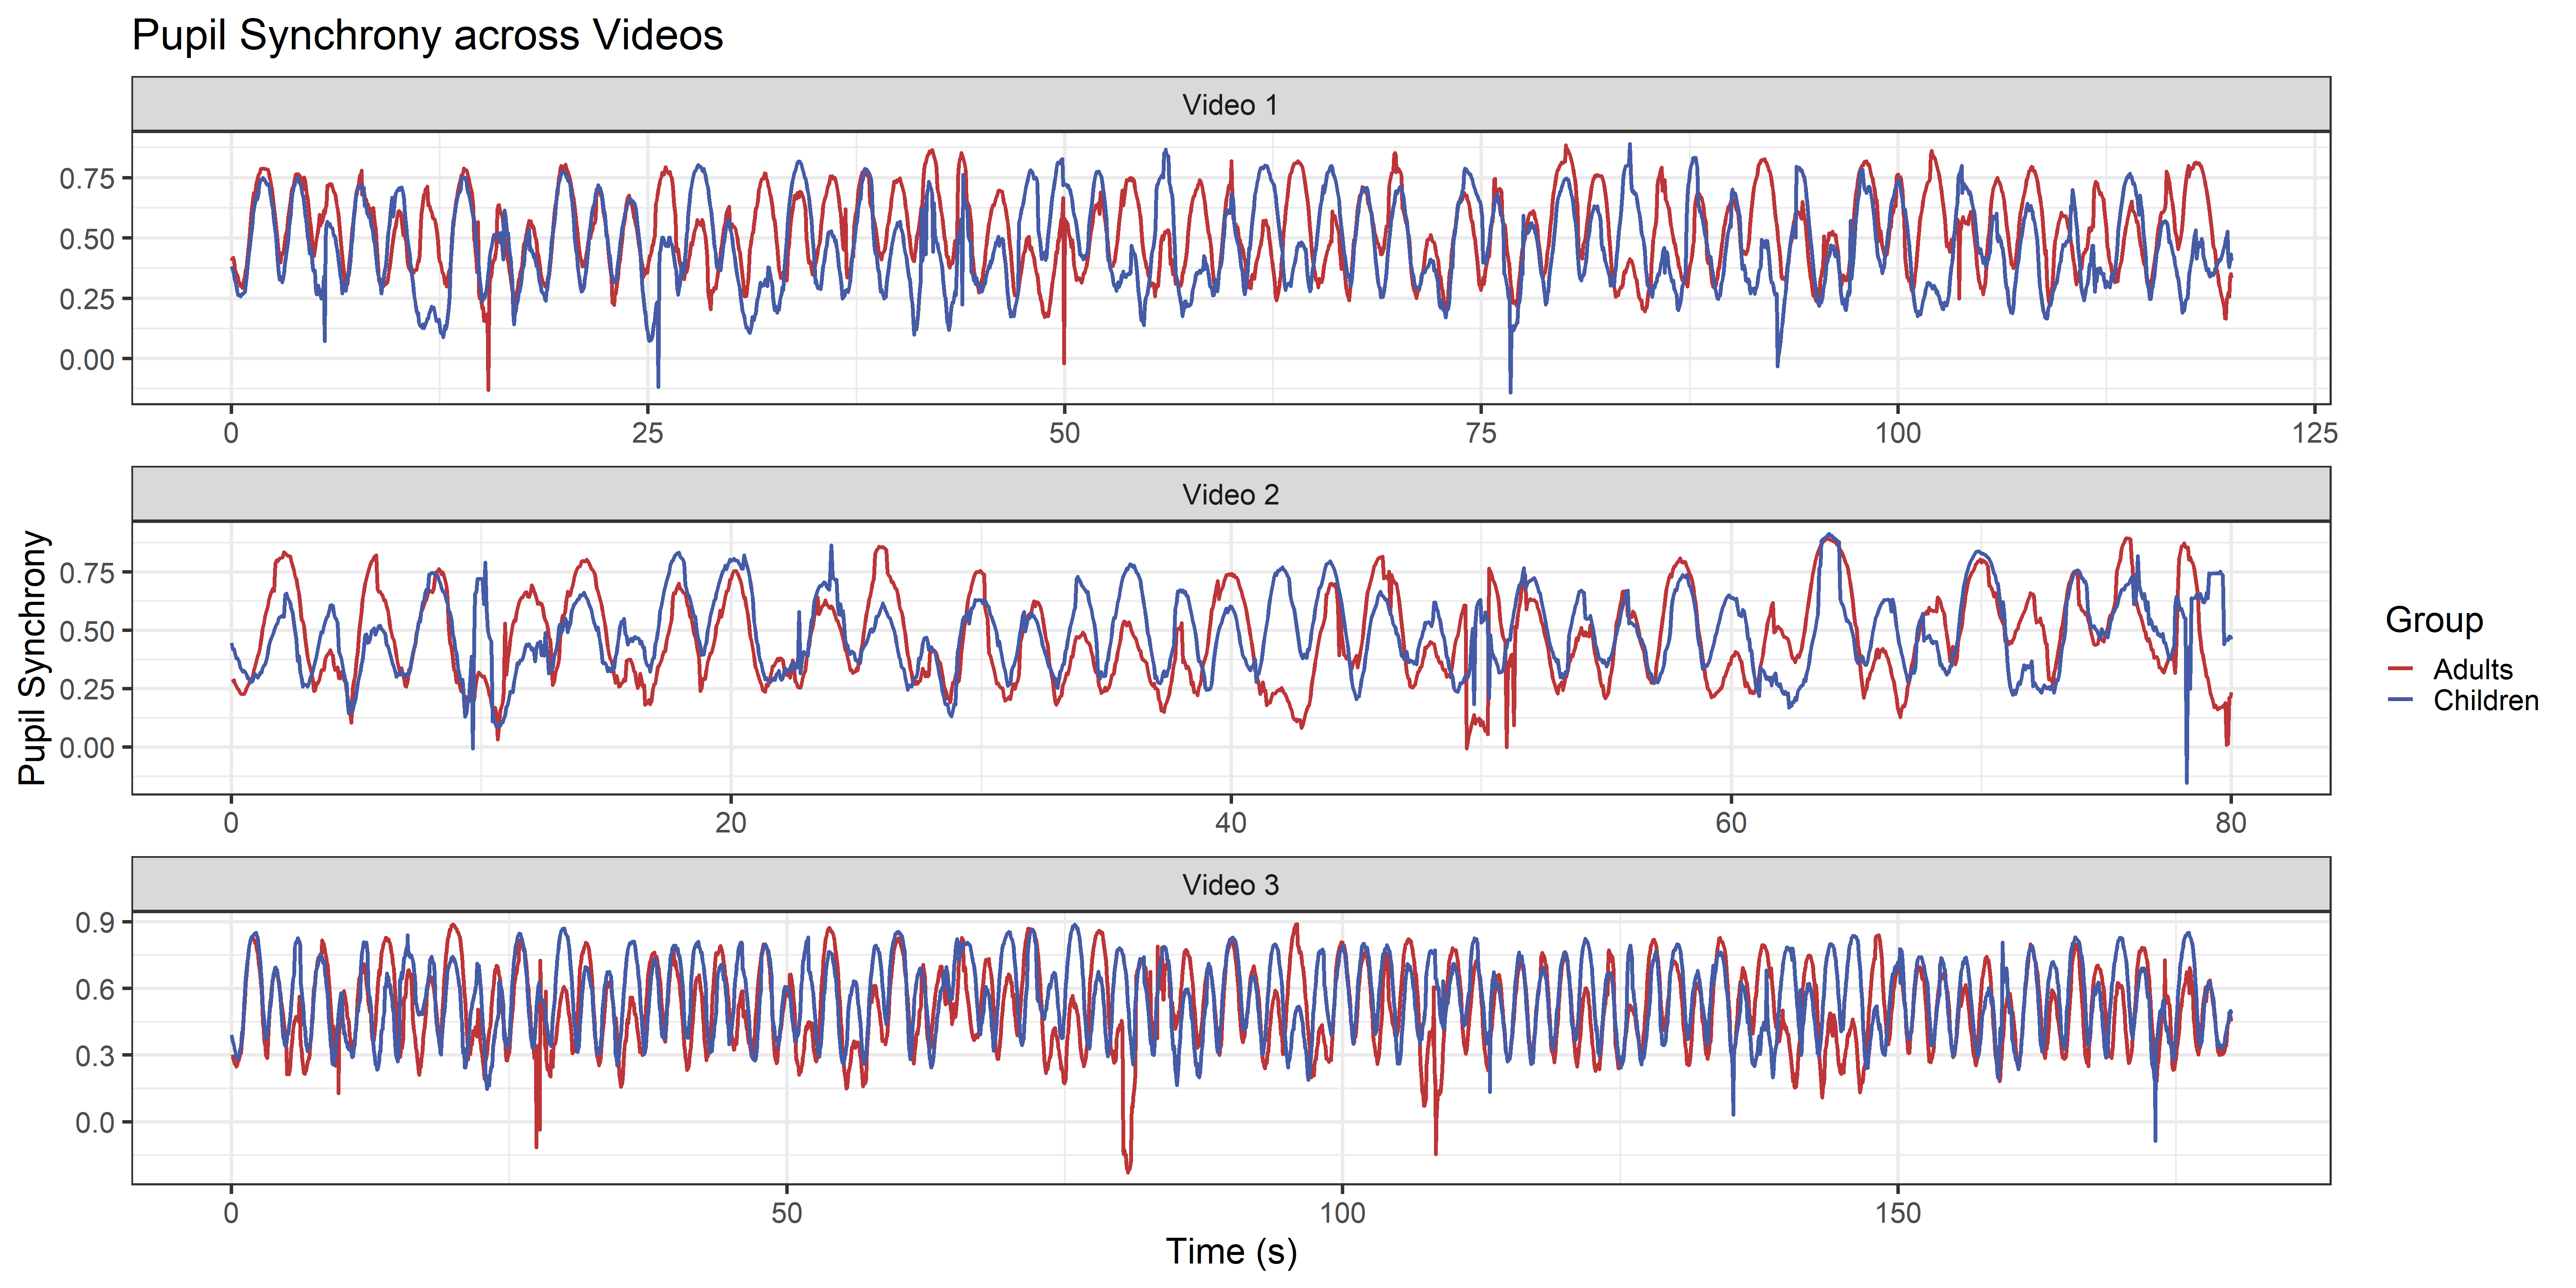

In [ ]:
ggplot(Final_synchrony, aes(x = Seconds, y = Synchrony, color = Group))+
  geom_line(lwd =1.1)+
  facet_wrap(~Video, scales = 'free', ncol = 1) +
  theme_bw(base_size = 20) +
  labs(title = "Pupil Synchrony across Videos",
       x = "Time (s)",
       y = "Pupil Synchrony")+
  scale_color_manual(values = c("#BD3538", "#455BA6"))

## Finding significant windows

In order to identify sections of our data where the difference in pupil
synchrony between children and adults is statistically significant,
we’ll use a rolling t-test function. The `RollingT()` function:

-   Converts input data to a dataframe and extracts synchrony values for
    children and adults.

-   Checks if more than the treshold of the values in either group’s
    window are NA. If so, it returns NA for both p-value and t-statistic
    to avoid unreliable results.

-   If there are sufficient non-NA values, it performs a two-sided
    t-test comparing the synchrony values between children and adults.

-   Returns the resulting p-value and t-statistic.

In [ ]:
# RollingT function performs a t-test on rolling windows of the data.
# It returns the p-value and t-statistic, or NA if the threshold of NA values is exceeded.
RollingT = function(df, tresholdT=0.75) {
  df = as.data.frame(df)
  Child_window = as.numeric(df$Children)
  Adu_window = as.numeric(df$Adult)
  
  # Check for NA values in each window and compare with threshold
  if (sum(is.na(Child_window)) / length(Child_window) > tresholdT || sum(is.na(Adu_window)) / length(Adu_window) > tresholdT) {
    return(c(Pval = NA, t_value = NA))
  } else {
    test_result = t.test(Child_window, Adu_window, paired = FALSE, alternative = "two.sided")
    return(c(Pval = test_result$p.value, t_value = test_result$statistic))
  }
}

### Running rolling ttest

Now that we have our `RollingT` function, we can apply it to our
synchrony data. However, before running the function, we need to prepare
our data in a specific format. This preparation involves:

-   Reshaping the data to a wide format
-   Separating the data by video stimulus
-   Arrange the data by Video and Seconds
-   Split the data to a list of dataframes based on the videos

Once the data is ready we run use `lappply()` to run on each dataframe
in the list a `rollapply()` function that calls the previously defined
`RollingT()` function.

After obtaining the results, we’ll:

-   Attach the extracted p-values and t-values to the original dataframe

-   Correct the p-values for each video using the false discovery rate
    (FDR) method to account for multiple comparisons

-   We create a column to indicate whether the corrected p-value is less
    than 0.05, providing a quick reference for statistical significance.
    (True - False)

In [ ]:
# Prepare data: Convert data to wide format with Group as column names
Synch_Pupil_Wide = Final_synchrony %>%
  pivot_wider(names_from = Group, values_from = Synchrony,
              id_cols = c("Seconds", 'Video')) %>%
  arrange(Video, Seconds)

# Split data by Video for separate processing
Video_list = Synch_Pupil_Wide %>%
  split(.$Video)

# Apply the RollingT function to each group separately and store results
Ttest_list = lapply(Video_list,
                     function(group_df) {
                       rollapply(group_df, width = window_size_Ttest,
                                 FUN = function(df) RollingT(df), by.column = FALSE, fill = NA, partial = TRUE)})


TTest_result = Synch_Pupil_Wide %>% 
  mutate(Pval = do.call(rbind, Ttest_list)[,1],
         Tval = do.call(rbind, Ttest_list)[,2]) %>% 
  
  group_by(Video) %>%
  mutate(Pval.fdr = as.numeric(p.adjust(Pval, method = "fdr"))) %>%
  ungroup() %>%
  mutate( Significance = case_when(
      Pval.fdr >= 0.05 ~ FALSE,
      Pval.fdr < 0.05 ~ TRUE,
      is.na(Pval.fdr) ~ FALSE))

### Find significant chunks

After obtaining our p-values and applying false discovery rate
correction, we’ll identify contiguous chunks of significant differences
between children and adults in pupil synchrony.

-   We create a column to identify contiguous significant periods in
    each video
-   Summarizing each streak to get its start time, end time, and
    duration
-   Keep only chunks that last 2 seconds or more

Finally after extracting all this information we plot the pupil dilation
synchorny and highlighting the chunks of data where there is a
significant difference.

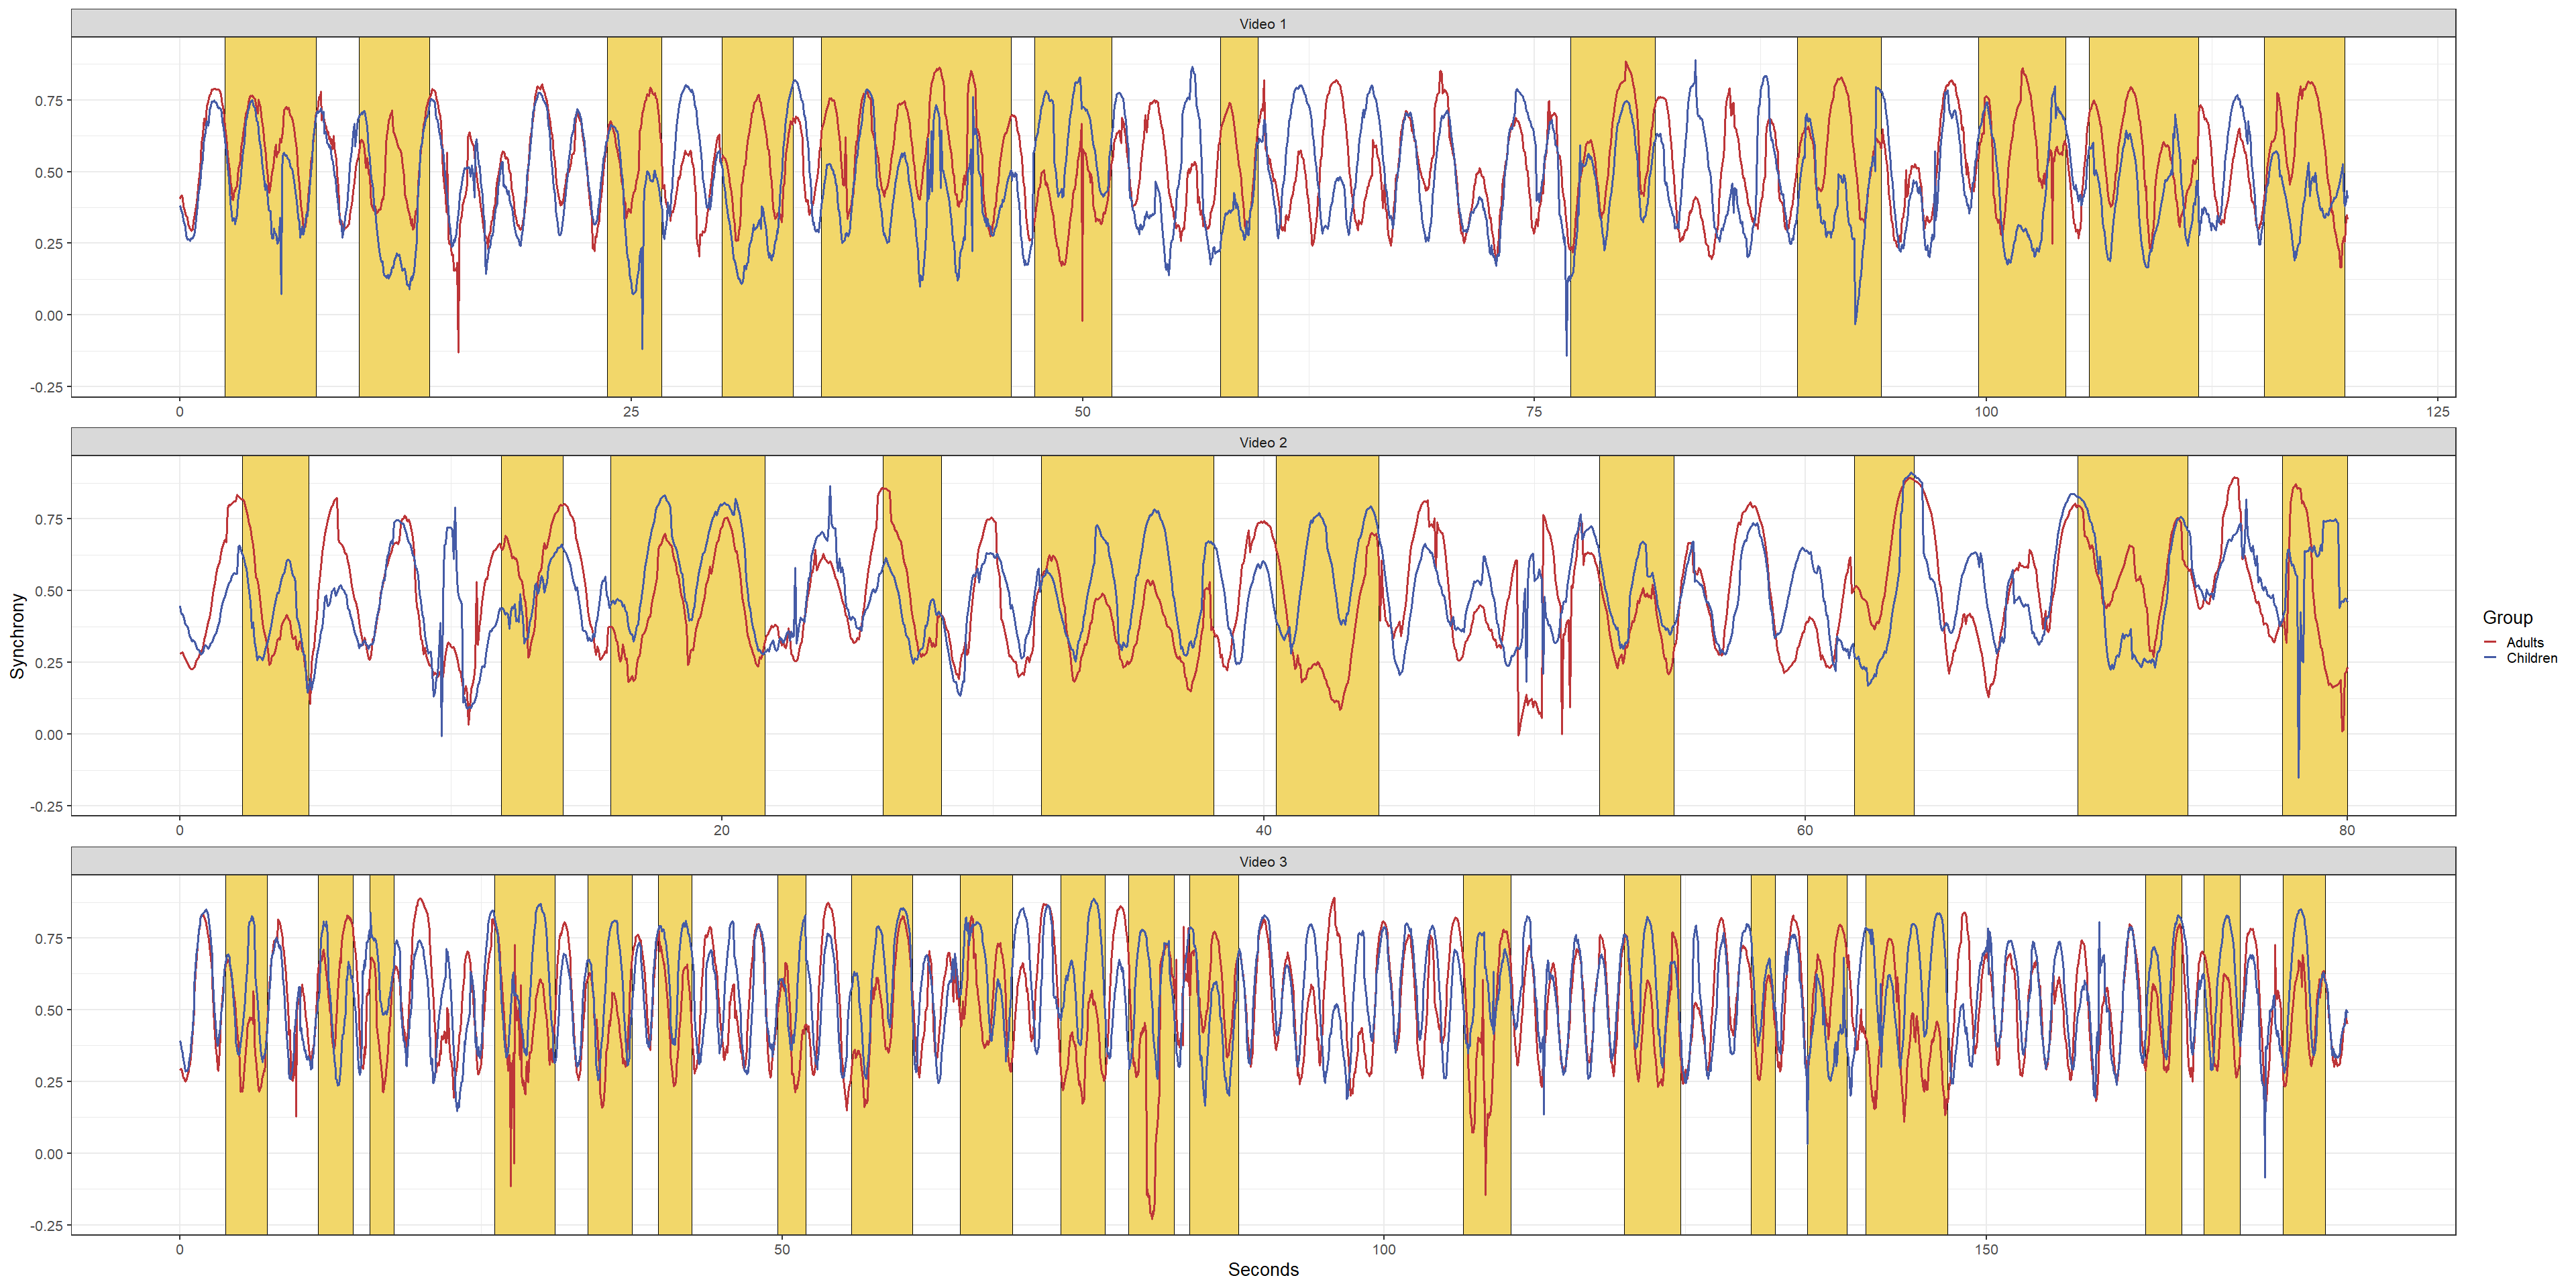

In [ ]:
## Identify contiguous chunks of significant results
Streak_Significance = TTest_result %>%
  group_by(Video) %>%
  # Create a streak column to identify contiguous significant periods
  mutate(Streak = cumsum(!Significance)) %>%
  ungroup() %>% 
  
  filter(Significance == TRUE) %>%
  group_by(Streak, Video) %>%
  summarize(
    START = min(Seconds, na.rm = T),  # Start time of the significant chunk
    END = max(Seconds, na.rm = T),    # End time of the significant chunk
    DUR = END - START     # Duration of the chunk
  ) %>%
  filter(DUR >= 2)  # Retain only chunks with a duration of 2 seconds or more


# Plot pupil synchrony and the significant chunks
ggplot(Final_synchrony, aes(y = Synchrony, x = Seconds, color = Group))+
  geom_rect(
    inherit.aes = FALSE, data = Streak_Significance,
    aes(xmin = START, xmax = END, ymin = -Inf, ymax = Inf), 
    fill = '#F2D76A', color = 'black'
  ) +
  
  geom_line(linewidth = 1.2) +
  facet_wrap(~Video, ncol=1, scales = 'free_x')+
  scale_color_manual(values = c("#BD3538", "#455BA6")) +
  theme_bw(base_size = 20)

# Randomization

In the paper we compared the chunks found in the pupil dilation with a
reference database. This database consisted of 1000 iterations where we
randomly assigned participants to either the Children or Adults group,
regardless of their actual age. The procedure is identical to what we’ve
seen so far. However, since we want to run this procedure 1000 times,
we’ll utilize the `parallel` library. This library provides a useful
function `parlapply()` that allows us to run multiple iterations of the
same function in parallel, significantly speeding up the process.

## Preparation

To start we import eh parallel library and we define some of the
settings that will be needed to run this procedure in parallel.

> **Warning**
>
> For the purpose of this tutorial, we’ll set the number of iterations
> to 10 to ensure the script runs quickly. It’s important to note that
> in a full analysis, you would typically use a much larger number of
> iterations (such as 1000) to obtain more robust results. The process
> remains the same regardless of the number of iterations; increasing
> this number simply provides a more comprehensive randomized dataset
> for comparison.

In [ ]:
library(parallel)

iterations = 1:10

# Initialize parallel processing
cl = makeCluster(detectCores() -2) # Use all available cores -2

# Export necessary objects and functions to each worker
clusterExport(cl, c("db", "calculate_running_correlation", "average_fisher_z_transform", "window_sizeP"))

# Load required libraries in each core
outpcl = clusterEvalQ(cl, {
  library(tidyverse)
  library(zoo)
})

### Wrapping in a function

To leverage parallel processing, we need to encapsulate our analysis in
a function that can be executed across multiple CPU cores. This function
will perform the same steps we’ve previously discussed, with two key
differences:

1.  At the beginning, it randomly reassigns the age group labels
    (Children or Adults) to the subjects.

2.  At the end, it adds an identifier for each iteration to our
    resulting dataframe.

In [ ]:
Parallel_Synhc = function(x) {
  
  # Randomize the group labels for each subject
  df = db %>%
    group_by(Subject) %>%
    mutate(Group = sample(c('Adults', 'Children'), size = n(), replace = TRUE)) %>%
    ungroup()
  
  
  # Split datafrme in chidlren and adults
  Children =  df %>%
    filter(Group == 'Children') %>% 
    arrange(Video) %>% 
    pivot_wider(names_from = Subject, values_from = PupilSize,
                id_cols = c("Seconds", "Video")) 
  
  Adults = df %>% 
    filter(Group == 'Adults') %>% 
    arrange(Video) %>% 
    pivot_wider(names_from = Subject, values_from = PupilSize,
                id_cols = c("Seconds", "Video")) 
  
  
  # Create list of dataframe for children
  Children_list = Children %>%
    split(.$Video) %>% 
    map(select, -(1:2))
    
  # Create list of dataframe for adults
  Adults_list = Adults %>%
    split(.$Video) %>% 
    map(select, -(1:2))
  
  
  #Running the correlation functions
  Children_synchrony = lapply(Children_list, calculate_running_correlation, window_sizeP = window_sizeP)
  Adults_sycnhrony = lapply(Adults_list, calculate_running_correlation, window_sizeP = window_sizeP)

    
  # Add sycnhrony values to original dataframe
  Children_synchrony = Children %>% 
    select(1:2) %>%
    mutate(Group = 'Children',
           Synchrony = do.call(c, Children_synchrony))
  
  Adults_sycnhrony = Adults %>% 
    select(1:2) %>%
    mutate(Group = 'Adults',
           Synchrony = do.call(c, Adults_sycnhrony))
  
  Final_synchrony = bind_rows(Children_synchrony, Adults_sycnhrony) %>% 
    mutate(Iteration = factor(x))
  
  return(Final_synchrony)
}

### Running the function

Now that we have defined our function, we can distribute it across
multiple CPU cores using `parlapply()`. This function will apply our
analysis to each iteration in parallel, significantly reducing
computation time. Here’s how we execute the process:

In [ ]:
# Run the Parallel_Synhc function in parallel for each iteration
Final_synchrony_randomized = parLapply(cl, iterations, Parallel_Synhc)
stopCluster(cl) # Stop the cluster after processing is complete

# Combine the results from all iterations
Final_synchrony_randomized = bind_rows(Final_synchrony_randomized)

This code launches our function across the cluster, processes all
iterations in parallel, and then combines the results into a single
comprehensive dataframe.

## Rolling Ttest

To extract the rolling t-test results from all iterations, we can apply
the same approach as before. We begin by defining a cluster of CPU cores
and exporting the necessary functions and variables.

In [ ]:
# Initialize parallel processing
cl = makeCluster(detectCores() -2) # Use all available cores -2

# Export necessary objects and functions to each worker
clusterExport(cl, c( "window_size_Ttest", "RollingT"))

# Load required libraries in each core
outpcl = clusterEvalQ(cl, {
  library(tidyverse)
  library(zoo)
})

As before, we wrap the rolling t-test process in a function designed to
run in parallel. This function will prepare the data, apply the t-test,
adjust p-values, and determine statistical significance.

In [ ]:
Parallel_RollingT = function(DF) {
  
  Iter = DF$Iteration[1]
  
  # Prepare data: Convert data to wide format with Group as column names
  Synch_Pupil_Wide = DF %>%
    pivot_wider(names_from = Group, values_from = Synchrony,
                id_cols = c("Seconds", 'Video')) %>%
    arrange(Video, Seconds)
  
  # Split data by Video for separate processing
  Video_list = Synch_Pupil_Wide %>%
    split(.$Video)
  
  # Apply the RollingT function to each group separately and store results
  Ttest_list = lapply(Video_list,
                       function(group_df) {
                         rollapply(group_df, width = window_size_Ttest,
                                   FUN = function(df) RollingT(df), by.column = FALSE, fill = NA, partial = TRUE)})
  
  
  TTest_result = Synch_Pupil_Wide %>% 
    mutate(Pval = do.call(rbind, Ttest_list)[,1],
           Tval = do.call(rbind, Ttest_list)[,2]) %>% 
    
    group_by(Video) %>%
    mutate(Pval.fdr = as.numeric(p.adjust(Pval, method = "fdr"))) %>%
    ungroup() %>%
    mutate( Significance = case_when(
        Pval.fdr >= 0.05 ~ FALSE,
        Pval.fdr < 0.05 ~ TRUE,
        is.na(Pval.fdr) ~ FALSE))
    
  return(TTest_result)
}

Finally, we prepare the data to be passed as a list, distribute it to
the cluster, and run the function for each iteration. Once all
iterations have been processed, we combine the resulting dataframes into
a single, consolidated dataframe.

In [ ]:
# split dataframe in list based on iterators
Final_synchrony_randomized_list = split(Final_synchrony_randomized, Final_synchrony_randomized$Iteration)

# Run the Parallel_RollingT function in parallel for each iteration
Final_Ttest_randomized = parLapply(cl, Final_synchrony_randomized_list, Parallel_RollingT)
stopCluster(cl) # Stop the cluster after processing is complete

# Combine the results from all iterations
Final_Ttest_randomized = bind_rows(Final_Ttest_randomized)